In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Requirements

In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!pip install -q datasets sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.2 MB/s eta 0:00:00


In [5]:
import os
import json
import random
from typing import Any, List, Tuple
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset
from datasets import load_dataset, Features, Value
from transformers import DonutProcessor, VisionEncoderDecoderModel
from torch import optim
from tqdm import tqdm

torch.manual_seed(2412)
np.random.seed(2412)
random.seed(2412)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/Phenikaa/NLP/dataset'
model_name = "naver-clova-ix/donut-base-finetuned-docvqa"

# Load model and Processor

In [7]:
processor = DonutProcessor.from_pretrained(model_name)
model = VisionEncoderDecoderModel.from_pretrained(model_name)

preprocessor_config.json:   0%|          | 0.00/359 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.01M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/478 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.74k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/803M [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.donut.modeling_donut_swin.DonutSwinModel'> is overwritten by shared encoder config: DonutSwinConfig {
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    14,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": [
    2560,
    1920
  ],
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "donut-swin",
  "num_channels": 3,
  "num_heads": [
    4,
    8,
    16,
    32
  ],
  "num_layers": 4,
  "patch_size": 4,
  "path_norm": true,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.50.0.dev0",
  "use_absolute_embeddings": false,
  "window_size": 10
}

Config of the decoder: <class 'transformers.models.mbart.modeling_mbart.MBartForCausalLM'> is overwritten by shared decoder config: MBartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "a

# Dataset:

base on Donut dataset

## Donut dataset format

In [8]:
added_tokens = []

class DonutDataset(Dataset):
    """
    DonutDataset which is saved in huggingface datasets format. (see details in https://huggingface.co/docs/datasets)
    Each row, consists of image path(png/jpg/jpeg) and gt data (json/jsonl/txt),
    and it will be converted into input_tensor(vectorized image) and input_ids(tokenized string).
    Args:
        dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
        max_length: the max number of tokens for the target sequences
        split: whether to load "train", "validation" or "test" split
        ignore_id: ignore_index for torch.nn.CrossEntropyLoss
        task_start_token: the special token to be fed to the decoder to conduct the target task
        prompt_end_token: the special token at the end of the sequences
        sort_json_key: whether or not to sort the JSON keys
    """

    def __init__(
        self,
        dataset_name_or_path: str,
        max_length: int,
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "<s>",
        prompt_end_token: str = None,
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.max_length = max_length
        self.split = split
        self.ignore_id = ignore_id
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
        self.sort_json_key = sort_json_key

        self.dataset = load_dataset(dataset_name_or_path, split=self.split)
        self.dataset_length = len(self.dataset)

        self.gt_token_sequences = []
        for sample in self.dataset:
            ground_truth = json.loads(sample["ground_truth"])
            if "gt_parses" in ground_truth:  # when multiple ground truths are available, e.g., docvqa
                assert isinstance(ground_truth["gt_parses"], list)
                gt_jsons = ground_truth["gt_parses"]
            else:
                assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
                gt_jsons = [ground_truth["gt_parse"]]

            self.gt_token_sequences.append(
                [
                    self.json2token(
                        gt_json,
                        update_special_tokens_for_json_key=self.split == "train",
                        sort_json_key=self.sort_json_key,
                    )
                    + processor.tokenizer.eos_token
                    for gt_json in gt_jsons  # load json from list of json
                ]
            )

        self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"<s_{k}>", fr"</s_{k}>"])
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in added_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj

    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add special tokens to tokenizer and resize the token embeddings of the decoder
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))
            added_tokens.extend(list_of_tokens)

    def __len__(self) -> int:
        return self.dataset_length - 1

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Load image from image_path of given dataset_path and convert into input_tensor and labels
        Convert gt data into input_ids (tokenized string)
        Returns:
            input_tensor : preprocessed image
            input_ids : tokenized gt_data
            labels : masked labels (model doesn't need to predict prompt and pad token)
        """
        sample = self.dataset[idx]

        # input_tensor
        pixel_values = processor(sample["image"].convert("RGB").resize((224,224)), random_padding=self.split == "train", return_tensors="pt").pixel_values
        input_tensor = pixel_values.squeeze()

        # input_ids
        processed_parse = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1
        input_ids = processor.tokenizer(
            processed_parse,
            add_special_tokens=False,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )["input_ids"].squeeze(0)

        if self.split == "train":
            labels = input_ids.clone()
            labels[
                labels == processor.tokenizer.pad_token_id
            ] = self.ignore_id  # model doesn't need to predict pad token
            labels[
                : torch.nonzero(labels == self.prompt_end_token_id).sum() + 1
            ] = self.ignore_id  # model doesn't need to predict prompt (for VQA)
            return input_tensor, input_ids, labels
        else:
            prompt_end_index = torch.nonzero(
                input_ids == self.prompt_end_token_id
            ).sum()  # return prompt end index instead of target output labels
            return input_tensor, input_ids, prompt_end_index, processed_parse

## Custom dataset format

In [11]:
class ResearchPosterDataset(Dataset):
    def __init__(
        self,
        dataset_path: str,
        max_length: int,
        processor: DonutProcessor,
        model: VisionEncoderDecoderModel,  # Add model parameter
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "<s>",
        prompt_end_token: str = "</s>",
    ):
        super().__init__()

        self.max_length = max_length
        self.split = split
        self.ignore_id = ignore_id
        self.processor = processor
        self.model = model  # Store model reference
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token

        # Load dataset
        self.dataset = load_dataset(
            "json",
            data_files={"train": os.path.join(dataset_path, "metadata.jsonl")},
            features=Features({
                "id": Value("string"),
                "file_name": Value("string"),
                "ground_truth": Value("string")
            })
        )["train"]

        # Process ground truth
        self.gt_token_sequences = []
        for sample in self.dataset:
            try:
                gt_dict = json.loads(sample["ground_truth"])
                self.gt_token_sequences.append(
                    self.json2token(gt_dict) + self.processor.tokenizer.eos_token
                )
            except json.JSONDecodeError:
                print(f"Invalid JSON in sample {sample['id']}")
                continue

        # Add special tokens
        self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def add_tokens(self, list_of_tokens: List[str]):
        """
        Modified token addition for XLMRobertaTokenizer since it doesn't recognize </s_title>...
        """
        # Add tokens to tokenizer
        newly_added_num = self.processor.tokenizer.add_tokens(list_of_tokens)

        # Resize model embeddings if new tokens were added
        if newly_added_num > 0:
            self.model.decoder.resize_token_embeddings(len(self.processor.tokenizer))


    def json2token(self, obj: dict) -> str:
        """
        Convert research poster JSON to token sequence
        """
        token_sequence = ""
        sections = ["title", "abstract", "method", "result"]

        for section in sections:
            if section in obj and obj[section].strip():
                # Add section tokens
                self.add_tokens([f"<s_{section}>", f"</s_{section}>"])

                # Add section content
                token_sequence += (
                    f"<s_{section}>"
                    + obj[section].strip()
                    + f"</s_{section}>"
                )

        return token_sequence

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        sample = self.dataset[idx]

        # Process image
        image_path = os.path.join(os.path.dirname(self.dataset.info.description), sample["file_name"])
        pixel_values = self.processor(
            Image.open(image_path).convert("RGB").resize((2560,1920)),
            random_padding=self.split == "train",
            return_tensors="pt"
        ).pixel_values.squeeze()

        # Process text
        gt_dict = json.loads(sample["ground_truth"])
        processed_parse = self.json2token(gt_dict) + self.processor.tokenizer.eos_token

        input_ids = self.processor.tokenizer(
            processed_parse,
            add_special_tokens=False,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )["input_ids"].squeeze(0)

        if self.split == "train":
            labels = input_ids.clone()
            labels[labels == self.processor.tokenizer.pad_token_id] = self.ignore_id
            labels[: torch.nonzero(labels == self.prompt_end_token_id).sum() + 1] = self.ignore_id
            return pixel_values, input_ids, labels
        else:
            prompt_end_index = torch.nonzero(input_ids == self.prompt_end_token_id).sum()
            return pixel_values, input_ids, prompt_end_index, processed_parse

In [12]:
train_dataset = ResearchPosterDataset(
    dataset_path=data_dir,
    processor=processor,
    model=model,
    max_length=768,
    split="train",
    task_start_token="<s>",
    prompt_end_token="</s>",
)

Generating train split: 0 examples [00:00, ? examples/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


## Dataloaders

In [13]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Training

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0): DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )

## Utils

In [18]:
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.
    """
    def __init__(self, patience=7,
                 verbose=False,
                 delta=0,
                 save_dir='',
                 trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            save_dir (str): Path for the checkpoint to be saved to.
                            Default: ''
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.save_dir = save_dir
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')

        best_model_path = os.path.join(self.save_dir, 'best_model.pt')
        torch.save(model.state_dict(), best_model_path)
        self.val_loss_min = val_loss


# Training Function
def train_model(model, data_loader, lr=3e-4, num_epochs=20, save_dir=None):
    # print('Setup...')
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True, min_lr=1e-6)
    early_stopping = EarlyStopping(patience=7, save_dir=save_dir)

    train_losses = []

    # print('Training...')
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')

        running_loss = 0.0

        with tqdm(data_loader, unit="batch") as tepoch:
            # print('Tepoch...')
            for batch in tepoch:
                tepoch.set_description(f"train Epoch {epoch+1}")
                optimizer.zero_grad()

                # Move only current batch to GPU
                pixel_values = batch[0].to(device, non_blocking=True)
                input_ids = batch[1].to(device, non_blocking=True)
                labels = batch[2].to(device, non_blocking=True)

                # Forward pass
                outputs = model(pixel_values=pixel_values, decoder_input_ids=input_ids, labels=labels)
                loss = outputs.loss


                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())

            epoch_loss = running_loss / len(data_loader)
            scheduler.step(epoch_loss)
            train_losses.append(epoch_loss)


            print(f'train Loss: {epoch_loss:.4f}')

            # Save model every 10 epochs
            if (epoch + 1) % 10 == 0:
                checkpoint_path = os.path.join(save_dir, f'model_epoch_{epoch+1}.pt')
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': epoch_loss,
                }, checkpoint_path)
                print(f'Model saved at epoch {epoch+1} to {checkpoint_path}')

            # Early stopping
            early_stopping(epoch_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

    return train_losses

## Training process

In [ ]:
lr = 3e-3
num_epochs = 50
save_dir = '/content/drive/MyDrive/Colab Notebooks/Computer_Vision/Final-term/model'
train_loss = train_model(model, lr, num_epochs, save_dir)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/50


train Epoch 1: 100%|██████████| 380/380 [02:58<00:00,  2.13batch/s, loss=0.579]


train Loss: 0.7878

Epoch 2/50


train Epoch 2: 100%|██████████| 380/380 [02:55<00:00,  2.17batch/s, loss=0.687]


train Loss: 0.7513

Epoch 3/50


train Epoch 3: 100%|██████████| 380/380 [02:58<00:00,  2.13batch/s, loss=0.527]


train Loss: 0.7161

Epoch 4/50


train Epoch 4: 100%|██████████| 380/380 [02:56<00:00,  2.15batch/s, loss=0.694]


train Loss: 0.7093

Epoch 5/50


train Epoch 5: 100%|██████████| 380/380 [02:59<00:00,  2.12batch/s, loss=0.685]


train Loss: 0.7075

Epoch 6/50


train Epoch 6: 100%|██████████| 380/380 [02:58<00:00,  2.13batch/s, loss=0.79]


train Loss: 0.6941

Epoch 7/50


train Epoch 7: 100%|██████████| 380/380 [02:58<00:00,  2.13batch/s, loss=0.724]


train Loss: 0.6947
EarlyStopping counter: 1 out of 7

Epoch 8/50


train Epoch 8: 100%|██████████| 380/380 [02:56<00:00,  2.16batch/s, loss=0.585]


train Loss: 0.6874

Epoch 9/50


train Epoch 9: 100%|██████████| 380/380 [02:56<00:00,  2.15batch/s, loss=0.678]


train Loss: 0.6919
EarlyStopping counter: 1 out of 7

Epoch 10/50


train Epoch 10: 100%|██████████| 380/380 [02:55<00:00,  2.16batch/s, loss=0.84]


train Loss: 0.6884
Model saved at epoch 10 to /content/drive/MyDrive/Colab Notebooks/Computer_Vision/Final-term/model/model_epoch_10.pt
EarlyStopping counter: 2 out of 7

Epoch 11/50


train Epoch 11: 100%|██████████| 380/380 [03:04<00:00,  2.06batch/s, loss=0.827]


train Loss: 0.6812

Epoch 12/50


train Epoch 12: 100%|██████████| 380/380 [02:56<00:00,  2.15batch/s, loss=0.787]


train Loss: 0.6836
EarlyStopping counter: 1 out of 7

Epoch 13/50


train Epoch 13: 100%|██████████| 380/380 [02:52<00:00,  2.20batch/s, loss=0.505]


train Loss: 0.6943
EarlyStopping counter: 2 out of 7

Epoch 14/50


train Epoch 14: 100%|██████████| 380/380 [02:55<00:00,  2.17batch/s, loss=0.761]


train Loss: 0.6813
EarlyStopping counter: 3 out of 7

Epoch 15/50


train Epoch 15: 100%|██████████| 380/380 [03:00<00:00,  2.10batch/s, loss=0.563]


train Loss: 0.6780

Epoch 16/50


train Epoch 16: 100%|██████████| 380/380 [02:57<00:00,  2.15batch/s, loss=0.638]


train Loss: 0.6799
EarlyStopping counter: 1 out of 7

Epoch 17/50


train Epoch 17: 100%|██████████| 380/380 [03:10<00:00,  1.99batch/s, loss=0.762]


train Loss: 0.6647

Epoch 18/50


train Epoch 18: 100%|██████████| 380/380 [02:57<00:00,  2.14batch/s, loss=0.769]


train Loss: 0.6733
EarlyStopping counter: 1 out of 7

Epoch 19/50


train Epoch 19: 100%|██████████| 380/380 [02:56<00:00,  2.16batch/s, loss=0.566]


train Loss: 0.6800
EarlyStopping counter: 2 out of 7

Epoch 20/50


train Epoch 20: 100%|██████████| 380/380 [02:55<00:00,  2.17batch/s, loss=0.519]


train Loss: 0.6764
Model saved at epoch 20 to /content/drive/MyDrive/Colab Notebooks/Computer_Vision/Final-term/model/model_epoch_20.pt
EarlyStopping counter: 3 out of 7

Epoch 21/50


train Epoch 21: 100%|██████████| 380/380 [02:56<00:00,  2.15batch/s, loss=0.677]


train Loss: 0.6750
EarlyStopping counter: 4 out of 7

Epoch 22/50


train Epoch 22: 100%|██████████| 380/380 [02:55<00:00,  2.17batch/s, loss=0.697]


train Loss: 0.6783
EarlyStopping counter: 5 out of 7

Epoch 23/50


train Epoch 23: 100%|██████████| 380/380 [02:55<00:00,  2.17batch/s, loss=0.615]


train Loss: 0.6726
EarlyStopping counter: 6 out of 7

Epoch 24/50


train Epoch 24: 100%|██████████| 380/380 [02:59<00:00,  2.12batch/s, loss=0.553]


train Loss: 0.6609

Epoch 25/50


train Epoch 25: 100%|██████████| 380/380 [02:58<00:00,  2.13batch/s, loss=0.871]


train Loss: 0.6655
EarlyStopping counter: 1 out of 7

Epoch 26/50


train Epoch 26: 100%|██████████| 380/380 [02:57<00:00,  2.14batch/s, loss=0.61]


train Loss: 0.6631
EarlyStopping counter: 2 out of 7

Epoch 27/50


train Epoch 27: 100%|██████████| 380/380 [02:54<00:00,  2.17batch/s, loss=0.691]


train Loss: 0.6665
EarlyStopping counter: 3 out of 7

Epoch 28/50


train Epoch 28: 100%|██████████| 380/380 [02:56<00:00,  2.15batch/s, loss=0.689]


train Loss: 0.6465

Epoch 29/50


train Epoch 29: 100%|██████████| 380/380 [02:55<00:00,  2.16batch/s, loss=0.743]


train Loss: 0.6588
EarlyStopping counter: 1 out of 7

Epoch 30/50


train Epoch 30: 100%|██████████| 380/380 [02:54<00:00,  2.18batch/s, loss=0.645]


train Loss: 0.6498
Model saved at epoch 30 to /content/drive/MyDrive/Colab Notebooks/Computer_Vision/Final-term/model/model_epoch_30.pt
EarlyStopping counter: 2 out of 7

Epoch 31/50


train Epoch 31: 100%|██████████| 380/380 [02:57<00:00,  2.15batch/s, loss=0.683]


train Loss: 0.6591
EarlyStopping counter: 3 out of 7

Epoch 32/50


train Epoch 32: 100%|██████████| 380/380 [02:54<00:00,  2.18batch/s, loss=0.768]


train Loss: 0.6486
EarlyStopping counter: 4 out of 7

Epoch 33/50


train Epoch 33: 100%|██████████| 380/380 [02:55<00:00,  2.17batch/s, loss=0.732]


train Loss: 0.6551
EarlyStopping counter: 5 out of 7

Epoch 34/50


train Epoch 34: 100%|██████████| 380/380 [02:56<00:00,  2.16batch/s, loss=0.655]


train Loss: 0.6597
EarlyStopping counter: 6 out of 7

Epoch 35/50


train Epoch 35: 100%|██████████| 380/380 [02:56<00:00,  2.16batch/s, loss=0.721]


train Loss: 0.6366

Epoch 36/50


train Epoch 36: 100%|██████████| 380/380 [02:56<00:00,  2.15batch/s, loss=0.66]


train Loss: 0.6423
EarlyStopping counter: 1 out of 7

Epoch 37/50


train Epoch 37: 100%|██████████| 380/380 [02:55<00:00,  2.17batch/s, loss=0.615]


train Loss: 0.6375
EarlyStopping counter: 2 out of 7

Epoch 38/50


train Epoch 38: 100%|██████████| 380/380 [02:54<00:00,  2.18batch/s, loss=0.672]


train Loss: 0.6395
EarlyStopping counter: 3 out of 7

Epoch 39/50


train Epoch 39: 100%|██████████| 380/380 [02:55<00:00,  2.17batch/s, loss=0.752]


train Loss: 0.6371
EarlyStopping counter: 4 out of 7

Epoch 40/50


train Epoch 40: 100%|██████████| 380/380 [02:54<00:00,  2.17batch/s, loss=0.54]


train Loss: 0.6368
Model saved at epoch 40 to /content/drive/MyDrive/Colab Notebooks/Computer_Vision/Final-term/model/model_epoch_40.pt
EarlyStopping counter: 5 out of 7

Epoch 41/50


train Epoch 41: 100%|██████████| 380/380 [02:55<00:00,  2.16batch/s, loss=0.624]


train Loss: 0.6438
EarlyStopping counter: 6 out of 7

Epoch 42/50


train Epoch 42: 100%|██████████| 380/380 [02:54<00:00,  2.18batch/s, loss=0.743]


train Loss: 0.6291

Epoch 43/50


train Epoch 43: 100%|██████████| 380/380 [02:56<00:00,  2.15batch/s, loss=0.855]


train Loss: 0.6314
EarlyStopping counter: 1 out of 7

Epoch 44/50


train Epoch 44: 100%|██████████| 380/380 [02:56<00:00,  2.16batch/s, loss=0.685]


train Loss: 0.6316
EarlyStopping counter: 2 out of 7

Epoch 45/50


train Epoch 45: 100%|██████████| 380/380 [02:53<00:00,  2.19batch/s, loss=0.478]


train Loss: 0.6253

Epoch 46/50


train Epoch 46: 100%|██████████| 380/380 [02:57<00:00,  2.14batch/s, loss=0.598]


train Loss: 0.6297
EarlyStopping counter: 1 out of 7

Epoch 47/50


train Epoch 47: 100%|██████████| 380/380 [02:52<00:00,  2.20batch/s, loss=0.69]


train Loss: 0.6224

Epoch 48/50


train Epoch 48: 100%|██████████| 380/380 [02:56<00:00,  2.16batch/s, loss=0.41]


train Loss: 0.6337
EarlyStopping counter: 1 out of 7

Epoch 49/50


train Epoch 49: 100%|██████████| 380/380 [02:55<00:00,  2.17batch/s, loss=0.56]


train Loss: 0.6312
EarlyStopping counter: 2 out of 7

Epoch 50/50


train Epoch 50: 100%|██████████| 380/380 [02:54<00:00,  2.18batch/s, loss=0.481]


train Loss: 0.6321
Model saved at epoch 50 to /content/drive/MyDrive/Colab Notebooks/Computer_Vision/Final-term/model/model_epoch_50.pt
EarlyStopping counter: 3 out of 7


## Evaluation

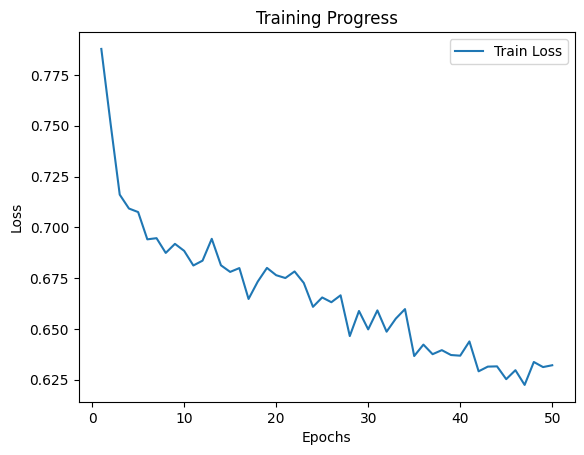

In [ ]:
from matplotlib.pyplot import plt
%matplotlib inline

# Plot Training Progress
plt.plot(range(1, len(train_loss)+1), train_loss, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import defaultdict

def postprocess_prediction(pred_seq, processor):
    """
    Convert model's tokenized output into structured JSON format.

    Args:
        pred_seq (str): Token sequence output from the model.
        processor: Donut processor (for handling special tokens).

    Returns:
        dict: Parsed structured output.
    """
    structured_output = {}
    sections = ["title", "abstract", "method", "result"]

    for section in sections:
        start_token = f"<s_{section}>"
        end_token = f"</s_{section}>"

        if start_token in pred_seq and end_token in pred_seq:
            structured_output[section] = pred_seq.split(start_token)[-1].split(end_token)[0].strip()

    return structured_output


def compute_f1_precision_recall_structured(pred_output, gt_output):
    """
    Compute Precision, Recall, and F1 Score for structured outputs.

    Args:
        pred_output (dict): Model's predicted output (postprocessed).
        gt_output (dict): Ground truth structured output.

    Returns:
        dict: Precision, Recall, and F1 score for each section + average F1.
    """
    scores = {}

    # Iterate over each section (title, abstract, method, result)
    for section in ["title", "abstract", "method", "result"]:
        pred_text = pred_output.get(section, "").split()
        gt_text = gt_output.get(section, "").split()

        # Convert to sets for flexible matching
        pred_set = set(pred_text)
        gt_set = set(gt_text)

        # Calculate TP, FP, FN
        tp = len(pred_set & gt_set)  # Correct words
        fp = len(pred_set - gt_set)  # Extra words
        fn = len(gt_set - pred_set)  # Missing words

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        scores[section] = {"precision": precision, "recall": recall, "f1": f1}

    # Compute the **average F1 score** across all fields
    avg_f1 = sum([scores[s]["f1"] for s in scores]) / len(scores)
    avg_precision = sum([scores[s]["precision"] for s in scores]) / len(scores)
    avg_recall = sum([scores[s]["recall"] for s in scores]) / len(scores)
    scores["average_f1"] = avg_f1
    scores["average_precision"] = avg_precision
    scores["average_recall"] = avg_recall

    return scores


@torch.no_grad()
def evaluate_model_per_section(model, dataset, processor, device="cuda"):
    """
    Evaluates the Donut model on each section (title, abstract, method, result).

    Args:
        model: Trained VisionEncoderDecoderModel.
        dataset: ResearchPosterDataset (test set).
        processor: DonutProcessor.
        device: Device to run the model on ("cuda" or "cpu").

    Returns:
        dict: Section-wise precision, recall, and F1 scores + average metrics.
    """
    model.to(device)
    model.eval()

    # Store scores for each section separately
    all_scores = defaultdict(list)

    for sample in dataset:
        pixel_values, input_ids, _, gt_parse = sample
        pixel_values = pixel_values.unsqueeze(0).to(device)

        # Generate predictions
        outputs = model.generate(pixel_values, max_length=dataset.max_length)
        pred_text = processor.tokenizer.batch_decode(outputs, skip_special_tokens=False)[0]

        # Convert predictions & ground truth into structured format
        pred_output = postprocess_prediction(pred_text, processor)
        gt_output = postprocess_prediction(gt_parse, processor)

        # Compute metrics per section
        scores = compute_f1_precision_recall_structured(pred_output, gt_output)

        # Store each section’s results
        for section in ["title", "abstract", "method", "result"]:
            all_scores[f"{section}_precision"].append(scores[section]["precision"])
            all_scores[f"{section}_recall"].append(scores[section]["recall"])
            all_scores[f"{section}_f1"].append(scores[section]["f1"])

    # Compute **final average metrics** for each section
    final_scores = {}
    for section in ["title", "abstract", "method", "result"]:
        final_scores[f"{section}_precision"] = sum(all_scores[f"{section}_precision"]) / len(all_scores[f"{section}_precision"])
        final_scores[f"{section}_recall"] = sum(all_scores[f"{section}_recall"]) / len(all_scores[f"{section}_recall"])
        final_scores[f"{section}_f1"] = sum(all_scores[f"{section}_f1"]) / len(all_scores[f"{section}_f1"])

    # Compute **overall average precision, recall, and F1** across sections
    final_scores["average_precision"] = sum([final_scores[f"{s}_precision"] for s in ["title", "abstract", "method", "result"]]) / 4
    final_scores["average_recall"] = sum([final_scores[f"{s}_recall"] for s in ["title", "abstract", "method", "result"]]) / 4
    final_scores["average_f1"] = sum([final_scores[f"{s}_f1"] for s in ["title", "abstract", "method", "result"]]) / 4

    return final_scores


def print_metrics(metrics):
    print(
        "{"
        + ", ".join(
            f"'{section}': {{'precision': {metrics[section]['precision']}, "
            f"'recall': {metrics[section]['recall']}, 'f1': {metrics[section]['f1']}}}"
            for section in ["title", "abstract", "method", "result"]
        )
        + f", 'average_f1': {metrics['average_f1']}, "
        + f"'average_precision': {metrics['average_precision']}, "
        + f"'average_recall': {metrics['average_recall']}"
        + "}"
    )

In [21]:
metrics = evaluate_model_per_section(model, train_dataset, processor)
print_metrics(metrics)

{'title': {'precision': 0.8181818181818182, 'recall': 1.0, 'f1': 0.9}, 'abstract': {'precision': 0.7608695652173914, 'recall': 0.875, 'f1': 0.813953488372093}, 'method': {'precision': 0.9512195121951219, 'recall': 0.8863636363636364, 'f1': 0.9176470588235294}, 'result': {'precision': 0.8431372549019608, 'recall': 0.9555555555555556, 'f1': 0.8958333333333333}, 'average_f1': 0.881858470132239, 'average_precision': 0.8433520376240731, 'average_recall': 0.929229797979798}
